# Cognitive PeopleBlending Science Art

Привет! Сейчас мы погрузимся в мир **Science Art**, где наука -- а именно **искусственный интеллект** -- поможет на создавать произведения искусства!

В этой лабораторной работе мы используем **[Face API](https://docs.microsoft.com/azure/cognitive-services/face/overview/?wt.mc_id=crpyface-github-dmitryso)** для создания работ в стиле **PeopleBlending** на основе набора фотографий. Мы будем создавать примерно такие фотографии:

<img src="https://raw.githubusercontent.com/shwars/FaceArt/master/notebooks/img/PhoBoGuy.png" width="40%"/>

Одна из возможностей [Face API](http://aka.ms/cognitive_face) позволяет нам извлекать из фотографии коорданиты ключевых точек лица, называемых  **Face Landmarks**. Узнав координаты опорных точек, мы используем OpenCV для применения к фотографии операций масштабирования и поворота (т.е. так называемого **аффинного преобразования**) для совмещения фотографий по ключевым точкам - например, глазам.

Эта техника была предложена [Дмитрием Сошниковым](http://soshnikov.com), под названием **Cognitive People Blending** (**когнитивное людесмешение**). Если Вы получите интересные художественные результаты, пожалуйста, [поделитесь ими](http://facebook.com/shwars), и не забывайте ссылаться на источник вдохновения.

### Подготовки

Для проведения манипуляций с изображениями нам необходима библиотека **OpenCV**. Она может быть включена в вашу Python-систему, но на всякий случай мы её инсталлируем с помощью `pip`. Также мы импортируем библиотеку `matplotlib` для вывода результатов.

In [1]:
import sys
!{sys.executable} -m pip install opencv-python
import cv2
import matplotlib.pyplot as plt

     |████████████████████████████████| 28.7MB 15kB/s  eta 0:00:01    |█████████▎                      | 8.3MB 704kB/s eta 0:00:29     |███████████████████████▌        | 21.1MB 4.1MB/s eta 0:00:02     |████████████████████████▍       | 21.8MB 4.1MB/s eta 0:00:02     |██████████████████████████████▌ | 27.4MB 2.3MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


/home/nbuser/anaconda3_420/lib/python3.5/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


### Извлекаем опорные точки лица

Для извлечения опорных точек лица мы используем [Microsoft Face API](https://azure.microsoft.com/services/cognitive-services/face/?wt.mc_id=crpyface-github-dmitryso). С помощью простого REST API мы можем извлечь много полезной информации о лице, включая пол, возраст, углы поворота головы, эмоции и ключевые точки:

![Facial Landmarks](https://raw.githubusercontent.com/shwars/FaceArt/master/notebooks/img/landmarks.jpg)

Мы можем легко вызвать API непосредственно по протоколу REST, но ещё лучше использовать существующий SDK, который доступе в составе [Azure SDK library](https://docs.microsoft.com/ru-ru/azure/cognitive-services/face/quickstarts/python-sdk/?wt.mc_id=crpyface-github-dmitryso).

Для более подробной информации о Face API и о том, как использовать его из других языков программирования, [посетите документацию на Microsoft Docs](https://docs.microsoft.com/ru-ru/azure/cognitive-services/face/index/?wt.mc_id=crpyface-github-dmitryso).

In [2]:
!{sys.executable} -m pip install azure-cognitiveservices-vision-face

     |████████████████████████████████| 71kB 3.9MB/s eta 0:00:011
     |████████████████████████████████| 92kB 5.8MB/s eta 0:00:011
     |████████████████████████████████| 163kB 25.5MB/s eta 0:00:01
     |████████████████████████████████| 51kB 16.9MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/51/bd/23c926cd341ea6b7dd0b2a00aba99ae0f828be89d72b2190f27c11d4b7fb/requests-2.22.0-py2.py3-none-any.whl
     |████████████████████████████████| 153kB 9.3MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/bc/a9/01ffebfb562e4274b6487b4bb1ddec7ca55ec7510b22e4c51f14098443b8/chardet-3.0.4-py2.py3-none-any.whl
  Found existing installation: requests 2.14.2
    Uninstalling requests-2.14.2:
      Successfully uninstalled requests-2.14.2
You should consider upgrading via the 'pip install --upgrade pip' command.


Для использования Face API нам необходим специальный ключ, а также интернет-адрес для вызова сервиса (Endpoint URL). Есть несколько способов получить ключ:

* Если у Вас есть подписка Microsoft Azure, [создайте ресурс Face API](https://docs.microsoft.com/en-us/azure/cognitive-services/cognitive-services-apis-create-account/?wt.mc_id=crpyface-github-dmitryso), и скопируйте ключ и URL оттуда.
* Вы всегда можете [создать бесплатную пробную подписку](https://azure.microsoft.com/free/?wt.mc_id=crpyface-github-dmitryso), по которой в течение месяца вы сможете расходовать определенный предоставленный вам кредитный лимит, а затем в течение года получать ограниченный набор сервисов бесплатно (для этого понадобится кредитная карта)
* Если у Вас нет облачной подписки, Вы можете попробовать Face API бесплатно в течение 7 дней - запросите ключ [здесь](https://azure.microsoft.com/try/cognitive-services/my-apis/?api=face-api&wt.mc_id=crpyface-github-dmitryso). Понадобится только Microsoft Account, который можно бесплатно завести на http://outlook.com. 

**Важно:** При использовании пробного ключа, у Face API будут некоторые ограничения по количеству изображений, которые вы сможете обработать (несколько тысяч), а также по частоте запросов (не более 20 запросов в минуту). Для обеспечения работы без ошибок, возможно придется вставлять паузы между запросами к сервису.

Полученный ключ и адрес Endpoint URL введите в ячейке ниже:

In [3]:
key = '--INSERT YOUR KEY HERE--'
endpoint = 'https://westus2.api.cognitive.microsoft.com' 
# You might need different endpoint, check the cognitive services page!

In [8]:
key = 'e408f9b6c8e34aee8f5567dbea67df30'
endpoint = 'https://westeurope.api.cognitive.microsoft.com'

Все вызовы к Face API производятся с помощью модуля `cognitive_face`, который мы для краткости назовём `cf`:

In [9]:
import azure.cognitiveservices.vision.face as cf
from msrest.authentication import CognitiveServicesCredentials
cli = cf.FaceClient(endpoint,CognitiveServicesCredentials(key))

Основные функции для обработки лица -- `face.detect_with_url` и `face.detect_with_stream`. Они извлекают из лица разную информацию в зависимости от передаваемых параметров -- в нашем случае необходимы facial landmarks:

In [13]:
res = cli.face.detect_with_url('https://2016.dotnext-piter.ru/assets/images/people/soshnikov.jpg',return_face_landmarks=True)
print(res[0])

{'recognition_model': None, 'face_attributes': None, 'face_landmarks': <azure.cognitiveservices.vision.face.models._models_py3.FaceLandmarks object at 0x7fd48929f828>, 'face_id': 'c5ed3684-7d2f-4c50-a499-5df620a0146a', 'additional_properties': {}, 'face_rectangle': <azure.cognitiveservices.vision.face.models._models_py3.FaceRectangle object at 0x7fd48929f710>}


### Получаем/загружаем изображения

Для экспериментов нам нужны изображения. В нашем примере мы возьмём 50 изображений Билла Гейтса, полученных из [Bing Image Search](https://docs.microsoft.com/azure/cognitive-services/bing-image-search/index/?wt.mc_id=crpyface-github-dmitryso). Поместим их в директорию `images`. **Важно:** Выполнение этой ячейки может занять длительное время, но вам придётся дождаться окончания выполнения перед тем, как продолжать.

In [11]:
import os
if not os.path.isdir('images'):
    !mkdir images
    !wget https://github.com/shwars/NeuroWorkshopData/raw/master/Data/Gates50.zip
    !unzip -q Gates50.zip -d images
    !rm Gates50.zip

--2019-11-08 21:23:59--  https://github.com/shwars/NeuroWorkshopData/raw/master/Data/Gates50.zip
Resolving webproxy (webproxy)... 10.36.6.1
Connecting to webproxy (webproxy)|10.36.6.1|:3128... connected.
Proxy request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/shwars/NeuroWorkshopData/master/Data/Gates50.zip [following]
--2019-11-08 21:23:59--  https://raw.githubusercontent.com/shwars/NeuroWorkshopData/master/Data/Gates50.zip
Connecting to webproxy (webproxy)|10.36.6.1|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 19574121 (19M) [application/zip]
Saving to: ‘Gates50.zip’

Gates50.zip         100%[===================>]  18.67M  1.07MB/s    in 16s     

2019-11-08 21:24:16 (1.14 MB/s) - ‘Gates50.zip’ saved [19574121/19574121]



Если вы хотите экспериментировать со своими фотографиями, загрузите их в диреторию `images` с помощью кнопки загрузки в Azure Notebooks -- это можно сделать на начальном экране Вашего проекта. Вы можете также использовать ноутбук **ImageSearch** для скачивания изображений, полученных в результате выполнения запроса **Bing Image Search**.

Посмотрим, как наш код справляется с обнаружением ключевых точек лица:

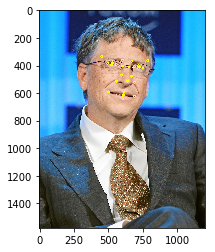

In [14]:
def imread(fn):
    im = cv2.imread(fn)
    return cv2.cvtColor(im,cv2.COLOR_BGR2RGB) if im is not None else None

img = imread('images/gates_0.jpg')
with open('images/gates_0.jpg','rb') as f:
    res = cli.face.detect_with_stream(f,return_face_landmarks=True)
for k,v in res[0].face_landmarks.as_dict().items():
    cv2.circle(img,(int(v['x']),int(v['y'])),7,(255,255,0),5)
plt.imshow(img)

**Важно:** В некоторых случаях в этом месте возникает ошибка SSL. Если это случилось, выполните вызов функции `detect_with_url`, и затем сразу предыдущую ячейку. Например, запустите следующий код (он также есть несколькими ячейками выше): 
```python
cli.face.detect_with_url('https://2016.dotnext-piter.ru/assets/images/people/soshnikov.jpg',return_face_landmarks=True)
```

Для наших экспериментов, давайте загрузим первые 10 изображений, пропустим их через Face API и извлечём ключевые точки. Мы сохраним картинки в массив `images`, а коорданиты точек - в массив `imagepoints`.

In [15]:
import glob
filenames = []
images = []
imagepoints = []
for fn in glob.glob("images/*")[0:13]:
    print("Processing {}".format(fn))
    with open(fn,'rb') as f:
        res = cli.face.detect_with_stream(f,return_face_landmarks=True)
    if len(res)>0:
        filenames.append(fn)
        images.append(imread(fn))
        imagepoints.append(res[0].face_landmarks.as_dict())

Processing images/gates_35.jpg
Processing images/gates_26.jpg
Processing images/gates_22.jpg
Processing images/gates_34.jpg
Processing images/gates_45.jpg
Processing images/gates_28.jpg
Processing images/gates_21.jpg
Processing images/gates_47.jpg
Processing images/gates_2.jpg
Processing images/gates_19.jpg
Processing images/gates_42.jpg
Processing images/gates_44.jpg
Processing images/gates_13.jpg


In [16]:
print(imagepoints[0])

{'mouth_right': {'y': 278.1, 'x': 548.5}, 'eyebrow_right_inner': {'y': 152.4, 'x': 518.3}, 'eyebrow_left_outer': {'y': 158.9, 'x': 422.1}, 'nose_left_alar_top': {'y': 219.4, 'x': 484.6}, 'eye_left_top': {'y': 177.3, 'x': 452.7}, 'nose_tip': {'y': 236.3, 'x': 510.0}, 'nose_left_alar_out_tip': {'y': 242.0, 'x': 476.4}, 'nose_right_alar_out_tip': {'y': 229.3, 'x': 535.6}, 'nose_root_left': {'y': 181.6, 'x': 489.0}, 'eyebrow_right_outer': {'y': 142.5, 'x': 569.7}, 'eye_right_top': {'y': 166.2, 'x': 544.9}, 'eye_right_bottom': {'y': 175.3, 'x': 545.1}, 'under_lip_top': {'y': 298.8, 'x': 510.1}, 'eyebrow_left_inner': {'y': 152.7, 'x': 481.9}, 'mouth_left': {'y': 289.6, 'x': 466.8}, 'eye_left_outer': {'y': 186.7, 'x': 437.4}, 'pupil_left': {'y': 181.3, 'x': 453.2}, 'eye_left_inner': {'y': 182.4, 'x': 468.2}, 'nose_right_alar_top': {'y': 212.1, 'x': 522.2}, 'under_lip_bottom': {'y': 314.1, 'x': 510.4}, 'upper_lip_bottom': {'y': 280.0, 'x': 510.1}, 'nose_root_right': {'y': 179.3, 'x': 511.8}, '

Посмотрим на несколько изображений:

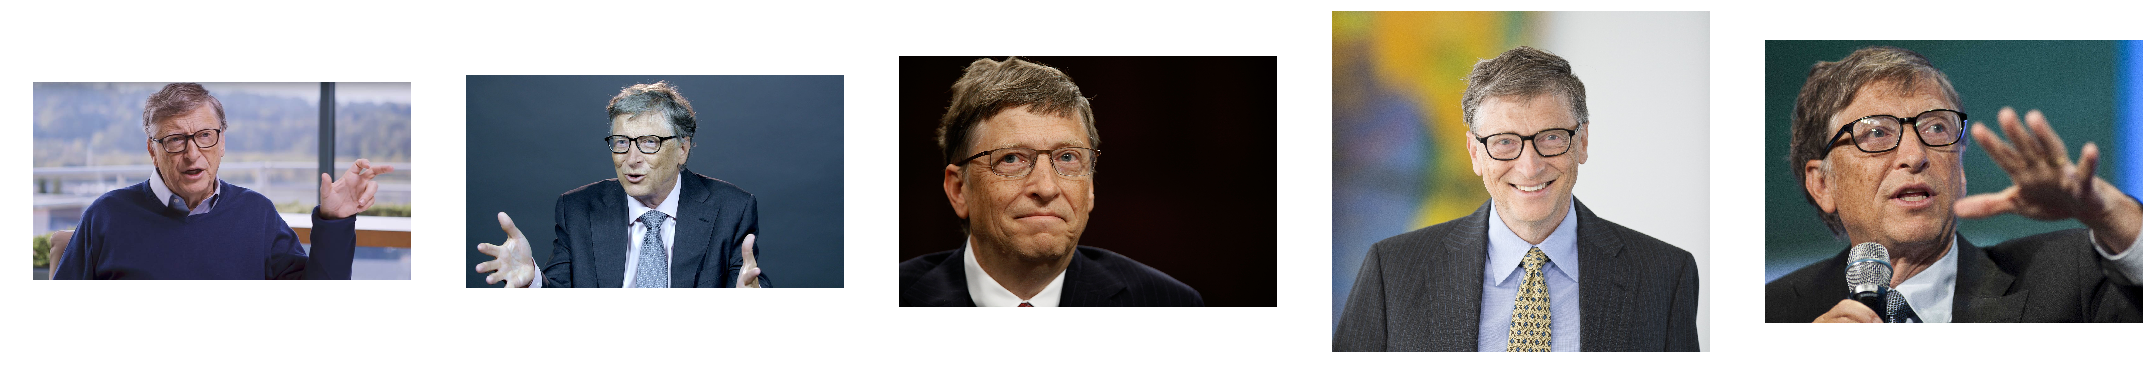

In [17]:
def display_images(l):
    n=len(l)
    fig,ax = plt.subplots(1,n)
    for i,im in enumerate(l):
        ax[i].imshow(im)
        ax[i].axis('off')
    fig.set_size_inches(fig.get_size_inches()*n)
    plt.tight_layout()
    plt.show()

display_images(images[:5])

## Аффинные преобразования

Чтобы выровнять все изображения по глазам, нам необходимо повернуть и масштабировать их. Для этого мы используем математическое понятие [**аффинного преобразования**](https://ru.wikipedia.org/wiki/Affine_transformation). 

Такое преобразование задается в двумерном пространстве матрицей, на которую надо умножить координаты точек, чтобы подвергнуть их преобразованию. Точнее,
$$
\left(\begin{matrix}x'\cr y'\cr 1\end{matrix}\right) = M\times\left(\begin{matrix}x\cr y\cr 1\end{matrix}\right)
$$
Не переживайте, если Вы это не понимаете.

В нашем случае мы хотим, чтобы координаты глаз у всех фотографий совпадали. Будем ориентироваться на размер целевого изображения $300\times300$, тогда координаты глаз могут быть $(130,120)$ и $(170,120)$. 

Аффинное преобразование на плоскости целиком задаётся тремя точками, т.е. нам необходимо указать какие три точки в какие другие три точки перейдут при преобразовании. В нашем случае две точки - это координаты глаз, и нужно придумать ещё одну. Хороший вариант - использовать середину рта, т.е. среднее положение между `mouth_left` и `mouth_right`.

Для получения преобразования по трем точкам используем функцию `getAffineTransform`, а для применения преобразования ко всему изображению -- `warpAffine` (она также обрезает изображение, чтобы оно помещалось в указанные целевые размеры). 

Таким образом, функция для выравнивания всех изображений будет иметь вид:

In [18]:
import numpy as np

target_triangle = np.float32([[130.0,120.0],[170.0,120.0],[150.0,160.0]])
size = 300

def affine_transform(img,attrs):
    mc_x = (attrs['mouth_left']['x']+attrs['mouth_right']['x'])/2.0
    mc_y = (attrs['mouth_left']['y'] + attrs['mouth_right']['y']) / 2.0
    tr = cv2.getAffineTransform(np.float32([(attrs['pupil_left']['x'],attrs['pupil_left']['y']),
                                            (attrs['pupil_right']['x'],attrs['pupil_right']['y']),
                                            (mc_x,mc_y)]), target_triangle)                                
    return cv2.warpAffine(img,tr,(size,size))

Выровняем с её помощью все фотографии:

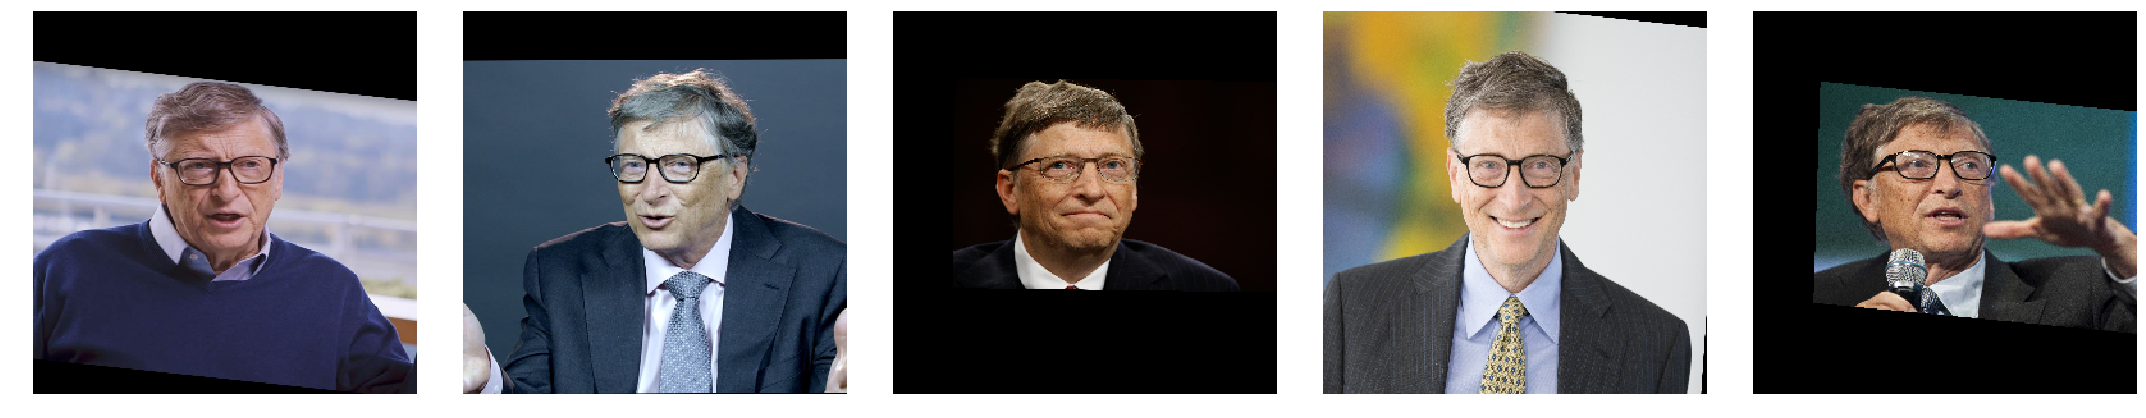

In [19]:
img_aligned = [affine_transform(i,a) for i,a in zip(images,imagepoints)]
display_images(img_aligned[:5])

## Смешивание изображений

Для получения результата нам осталось смешать эти изображения. Поскольку изображения в Python представляются обычными массивами `numpy`, смешивание можно произвести просто вычисляя среднее значение покоординатно. Например, для изображений $A$ и $B$, смешанное изображение вычисляется как $C_{i,j,c} = \frac{1}{2}(A_{i,j,c}+B_{i,j,c})$ (где под $c$ мы понимаем канал цветности, т.е. $c\in\{1,2,3\}$).

В более общем случае, если $I^{(1)}, I^{(2)}, \dots, I^{(n)}$ - это изображения, которые мы хотим смешать с весами $\alpha_1, \alpha_2, \dots, \alpha_n$, такими, что $\alpha_1+\alpha_2+\dots+\alpha_n=1$, то результирующее изображение будет вычисляться так: 
$$
M_{i,j,c} = \sum_{k=1}^n\alpha_k I^{(k)}_{i,j,c}
$$
или, в матричном виде
$$
M = \sum_{k=1}^n\alpha_k I^{(k)} = \alpha_1 I^{(k)} + \dots + \alpha_n I^{(n)}
$$


In [24]:
def merge(images,wts=None):
    res = np.zeros_like(images[0],dtype=np.float32)
    if wts is None:
        wts = np.ones(len(images))
    wts /= np.sum(wts)
    for n,i in enumerate(images):
        res += wts[n]*i.astype(np.float32)/255.0
    return res

В этой функции, если мы не указываем вектор весов -- он подразумевается равным $1\over n$.

Вот как работает смешивание двух картинок:

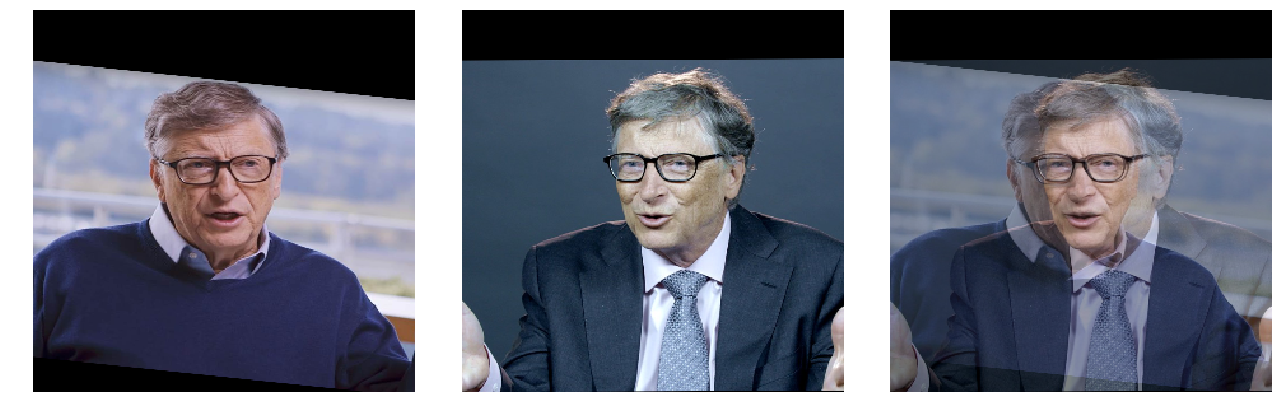

In [25]:
display_images([img_aligned[0],img_aligned[1],merge(img_aligned[0:2])])

А после смешивания всех картинок получаем:

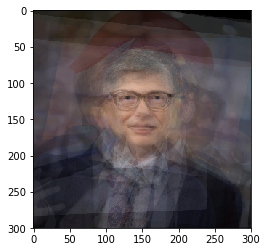

In [26]:
res = merge(img_aligned)
plt.imshow(res)

Мы можем сразу сгенерировать несколько изображений, смешивая картинки со случайными весами:

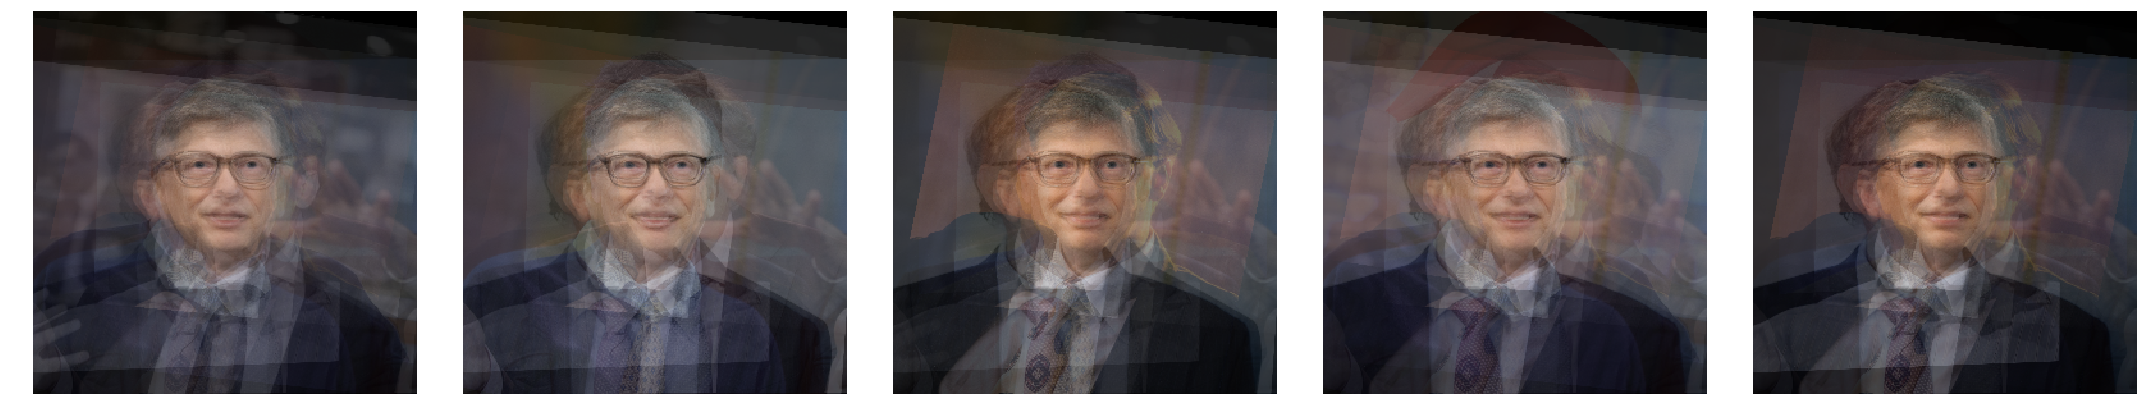

In [27]:
imgs = [merge(img_aligned,np.random.random(len(img_aligned))) for _ in range(5)]
display_images(imgs)

## Продолжаем эксперименты!

Продолжайте экспериментировать, пока вы не получите действительно оригинальные результаты! Некоторые идеи:

* Просто запустите код несколько раз и посмотрите, какие результаты получаются
* Используйте свои фотографии, фотографии себя разного возраста, а также фотографии разных людей, чтобы смешать их вместе!
* С помощью ноутбука `ImageGatherer` скачайте разные фото из интернета и пробуйте на них! 
* Попробуйте совмещать различные опорные точки лица
* Вместо совмещения, поэкспериментируйте с расположением точек лица по какому-нибудь правилу, например, по окружности

## Поделитесь результатами!

Пожалуйста, обязательно делитесь полученными результатами! Вы можете [послать их сообщением в вк](http://vk.com/shwars), но ещё лучше -- разместите их в социальных сетях с хештегом **#peopleblending**. Например:

> Ого, смотрите что я сотворил с использованием технологии #peopleblending http://bit.ly/peopleblending!

После того, как Вы разместили пост, пошлите нам ссылку на него с помощью ячейки ниже! Вам нужно будет ввести своё имя или псевдоним, ссылку на пост и краткое название мероприятия, на котором вы услышали про эту технику. Кстати, мы используем здесь вызов REST-сервиса, который был создан с помощью [Azure Functions](https://docs.microsoft.com/azure/azure-functions/?wt.mc_id=crpyface-github-dmitryso).

In [30]:
name = 'John Doe, Jr.'
url = 'http://twitter.com/link-to-my-post'
event = 'pycon.de' # use pycon.de, pycon.ee, pycon.bal or any other event name

import requests

r = requests.get(url='https://contestman.azurewebsites.net/api/cfsubmit', params = { "name" : name, "url" : url, "event" : event })
r.content

b'Your submission is accepted, John Doe, Jr.'

### Уборка

Чтобы сохранять вселенную чистой, мы удали за собой директорию `images`. Если Вы загрузили туда ценные фотографии и планируете вернуться и с ними поэкспериментировать ещё - директорию можно не удалять.

In [28]:
!rm -rf images